In [87]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy
import h5py
import seaborn as sns
from scipy.stats import gmean
from matplotlib.image import NonUniformImage

In [88]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.cosmology import z_at_value, Planck18, Planck13
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089, Tcmb0=2.725)

In [89]:
merger_file="blackhole_mergers_tng300.hdf5"
merger_data=h5py.File(merger_file, 'r')
M_1=np.maximum(merger_data['mass_out'],merger_data['mass_in'])*1e10/.6774
M_2=np.minimum(merger_data['mass_out'],merger_data['mass_in'])*1e10/.6774
z=np.array(merger_data['time'])**(-1)-1

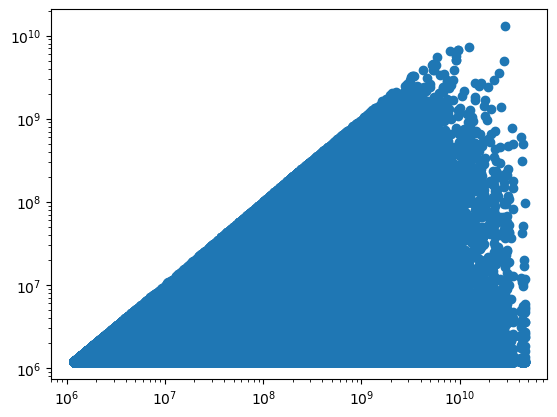

In [90]:
plt.scatter(M_1, M_2)
plt.yscale('log')
plt.xscale('log')

In [91]:
def mass_factor(M, x1=6, y1=10, x2=7, y2=1):
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    M_new = []
    Fact = []
    
    for i in range(len(M)):
        if M[i] < 10 ** x2:
            factor = m * np.log10(M[i]) + b
            factor=np.random.normal(loc=factor,scale=factor/10)
            if factor<.9:
                factor=.9
        else: 
            factor = 1
        m_i = M[i] / factor
        M_new.append(m_i)
        Fact.append(factor)
    M_new=np.array(M_new)
    Fact=np.array(Fact)
    return M_new, Fact


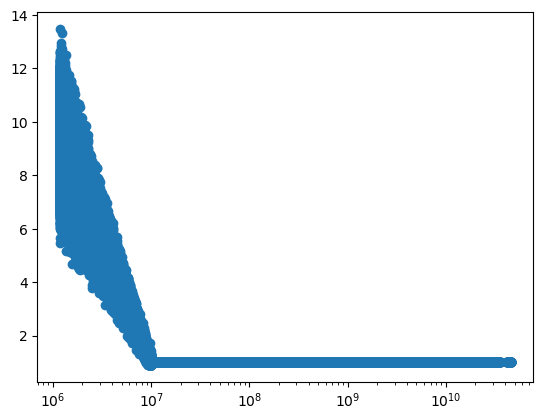

In [92]:
M_1new, fact_M1 = mass_factor(M_1)
plt.scatter(M_1, fact_M1)
plt.xscale('log')

In [93]:
M_2new, fact_M2 = mass_factor(M_2)

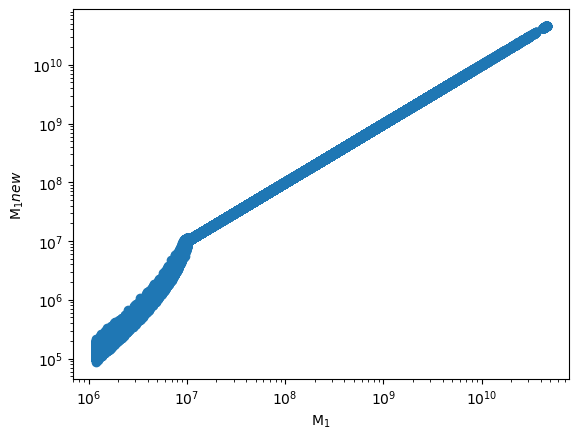

In [94]:
plt.scatter(M_1, M_1new)
plt.xlabel('M$_1$')
plt.ylabel('M$_1new$')
plt.xscale('log')
plt.yscale('log')


In [95]:
def gw_calc(M_1, M_2,z=0.0001):
    M=M_1+M_2
    M_o=1
    mu=(M_1*M_2)**(3/5)/M**(1/5)
    d_l=cosmo.luminosity_distance(z).value
    pi=scipy.constants.pi
    f_c=3.9*(M/(10**4*M_o))**-1*(1+z)**-1
    h_c=8/(10**(1/2))*(mu)**(5/3)/(d_l*3.086e22)*(pi*f_c)**(2/3)
    return f_c, h_c, mu
 


In [96]:
lisa_f = []
lisa_h = []
for line in open('LISAstrain.txt', 'r'):
    lines = [i for i in line.split()]
    lisa_f.append(float(lines[0]))
    lisa_h.append(float(lines[1]))


In [97]:
def snr_calc(f_c, h_c, lisa_f=lisa_f, lisa_h=lisa_h):
    mask_snr=~((np.min(lisa_f)<f_c) & (np.max(lisa_f)>f_c))
    h_interp= np.interp(f_c, lisa_f, lisa_h)
    snr=h_c/h_interp
    snr[mask_snr]=np.nan
    return snr



In [98]:
def avg_hist(x,y,z, bins=(20,20), c1='Spectral', c2= 'Spectral',  labelx=None, labely=None,
            labelz=None, norm1=matplotlib.colors.LogNorm(), logweight=True, 
            norm2=None, vmin=None,vmax=None):
 #            norm2=matplotlib.colors.LogNorm(vmin=None, vmax=None) ):
    z_mask=((~np.isnan(z))&(~np.isnan(x))&(~np.isnan(y)))
    x=x[z_mask]
    y=y[z_mask]
    z=z[z_mask]
    H_num, xedges, yedges = np.histogram2d(x, y, bins=bins)
    if logweight:
        z=np.log10(z)
    H_z, xedges, yedges = np.histogram2d(x,y, bins=(xedges, yedges), weights=z)
    H_num=H_num.T
    H_z=H_z.T
    plt.figure(figsize=(15,10))
    plt.subplot(2, 1, 1)
    plt.imshow(H_num, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
           cmap= c1, norm=norm1)
 
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.colorbar(label='Numbers')

    plt.subplot(2,1,2)
    plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               cmap=c2, norm=norm2, vmax=vmax,vmin=vmin)
    #print(np.min(H_z/H_num), np.max(H_z/H_num))
    #print(H_z/H_num)
   
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.colorbar(label=labelz)
   
    
    plt.tight_layout()
    plt.gca().set_aspect('equal')

    

In [99]:
f_c0, h_c0, mu0= gw_calc(M_1,M_2)
f_c1, h_c1, mu1= gw_calc(np.array(M_1new),np.array(M_2new))


In [100]:
snr0=snr_calc(f_c0, h_c0)
snr1=snr_calc(f_c1, h_c1)

C:\Users\karma\AppData\Local\Temp\ipykernel_31444\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


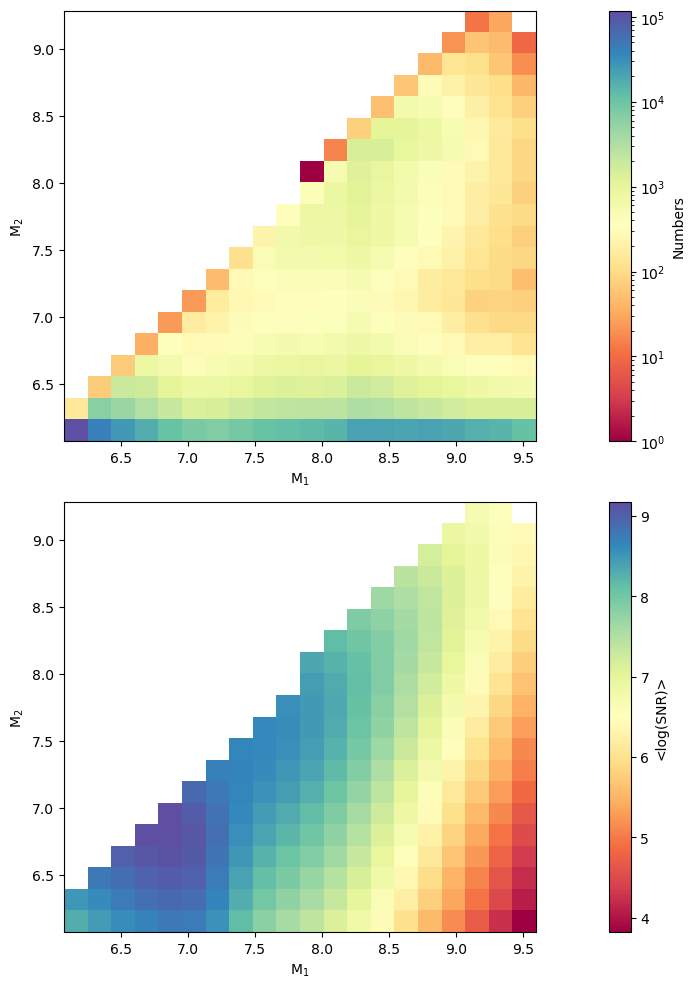

In [101]:
avg_hist(np.log10(M_1),np.log10(M_2),snr0,labelx='M$_1$',labely='M$_2$',labelz='<log(SNR)>')

C:\Users\karma\AppData\Local\Temp\ipykernel_31444\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


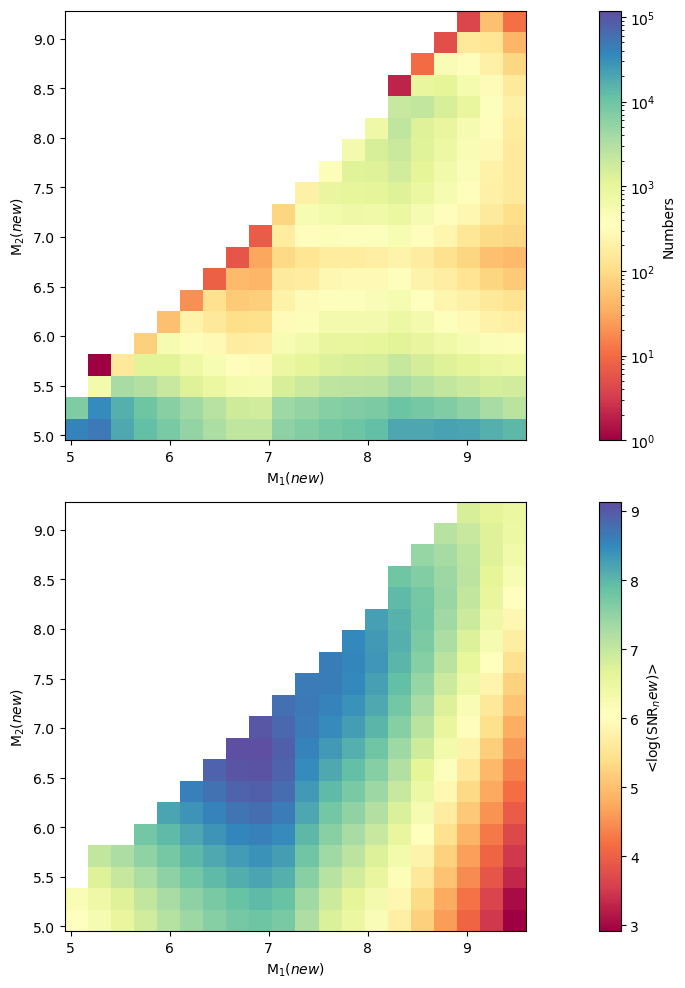

In [102]:
avg_hist(np.log10(M_1new),np.log10(M_2new),snr1,labelx='M$_1(new)$',labely='M$_2(new)$',labelz='<log(SNR$_new$)>')

C:\Users\karma\AppData\Local\Temp\ipykernel_31444\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


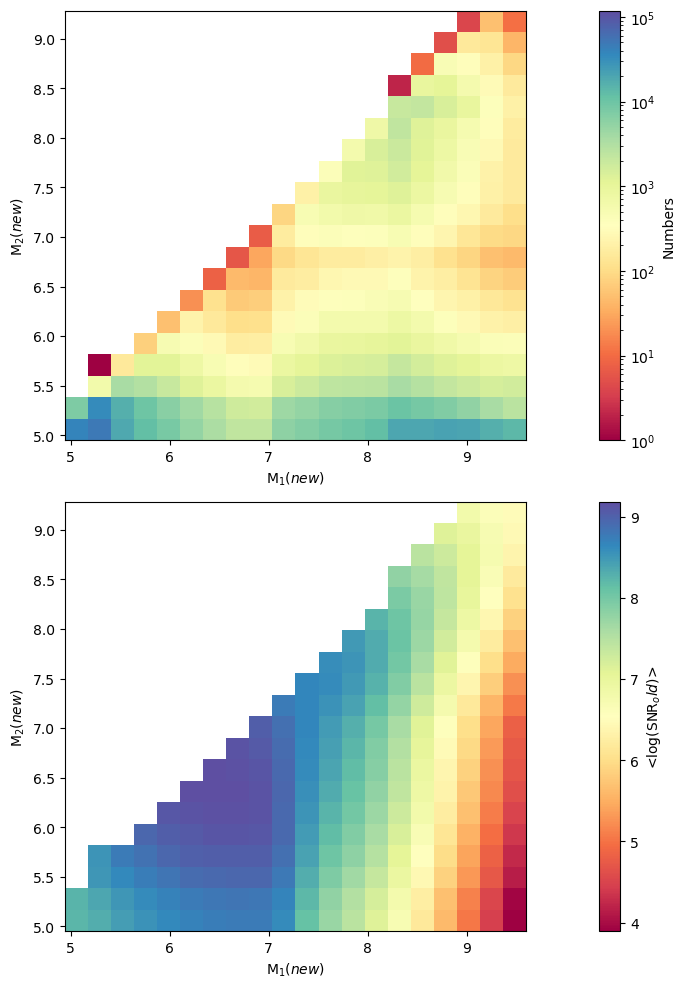

In [103]:
avg_hist(np.log10(M_1new),np.log10(M_2new),snr0,labelx='M$_1(new)$',labely='M$_2(new)$',labelz='<log(SNR$_old$)>')

C:\Users\karma\AppData\Local\Temp\ipykernel_31444\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


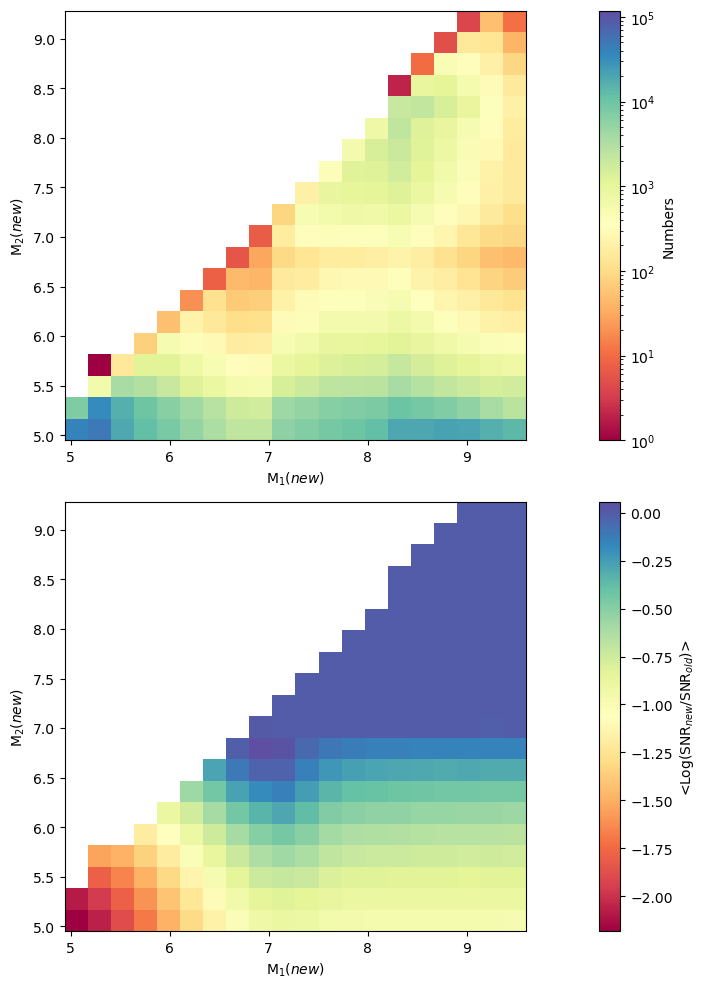

In [118]:
avg_hist(np.log10(M_1new),np.log10(M_2new),snr1/snr0,labelx='M$_1(new)$',labely='M$_2(new)$',labelz='<Log(SNR$_{new}$/SNR$_{old}$)>')

C:\Users\karma\AppData\Local\Temp\ipykernel_31444\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


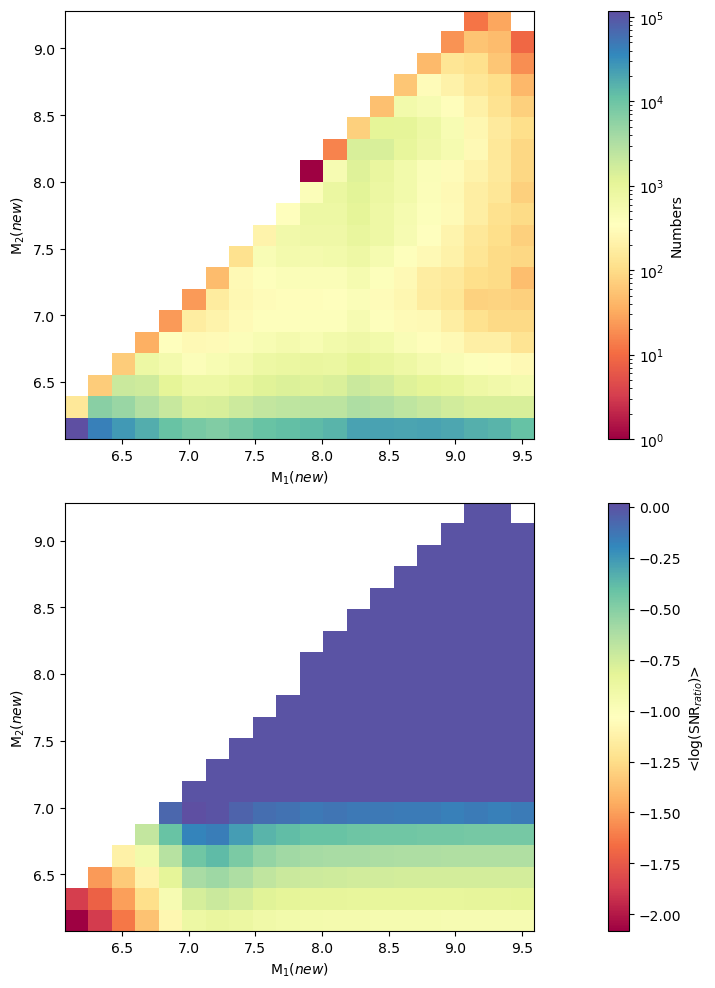

In [109]:
avg_hist(np.log10(M_1),np.log10(M_2),snr1/snr0,labelx='M$_1(new)$',labely='M$_2(new)$',labelz='<log(SNR$_{ratio}$)>')